In [89]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
from numpy import linalg as LA
plt.rcParams['text.usetex'] = False
plt.rcParams['pcolor.shading']='auto'

# Relaxation method for Laplace equation
 The solution $V(\mathbf{r})$ to a Laplace equaiton has no maximum or minimum. The potential at one position is the average of the neighborhood.
 $$V(x,y) = \frac{1}{4} \left[V(x+dx,y)+V(x,y+dy)+V(x-dx,y)+V(x,y-dy)\right].$$
Using this idea, we can solve the potentail inside a domain $\mathcal V$, given the potential $V$ on the surface $\mathcal S$.
## Effective Resistance
In this example, we will use the relaxation method to compute the resistance of a nano-device.

In [90]:
lx = 1e-7 ## m
ly = 1e-8 ## m
dx = 0.5e-9/4 ## m
dy = dx ## m Note that # should make dy = dx


Nx = int(np.rint(lx/dx)) ## number of x-grids. rint: Round elements of the array to the nearest integer.
Ny = int(np.rint(ly/dy)) ## number of y-grids. 
xv = np.linspace(-lx/2,lx/2,Nx)
yv = np.linspace(-ly/2,ly/2,Ny)
xm, ym = np.meshgrid(xv, yv)
pot = np.zeros((Nx,Ny))
pot = -0.5 + (lx/2 - np.transpose(xm)) / lx; # a good guess

In [91]:
## BCs
Ng = int(np.rint(5e-9/dx)) # number of grids of the gate (5 nm) 
def appl_BCs(pot_in):
    pot_out = pot_in
    pot_out[0,0:Ny-1] = pot_out[1,0:Ny-1] # left Neumann BCs dv/dn =0  
    pot_out[Nx-1,0:Ny-1] = pot_out[Nx-2,0:Ny-1] # right Neumann BCs dv/dn =0
    pot_out[0:Nx,0] = pot_out[0:Nx,1]  # bottom Neumann BCs dv/dn =0
    pot_out[0:Ng,Ny-1] = 0.5 # positive electrode
    pot_out[Nx-Ng:Nx,Ny-1] = -0.5 # negative electrode
    pot_out[Ng:Nx-Ng,Ny-1] = pot_out[Ng:Nx-Ng,Ny-2] # top Neumann BCs dv/dn =0
    return pot_out

pot =  appl_BCs(pot)


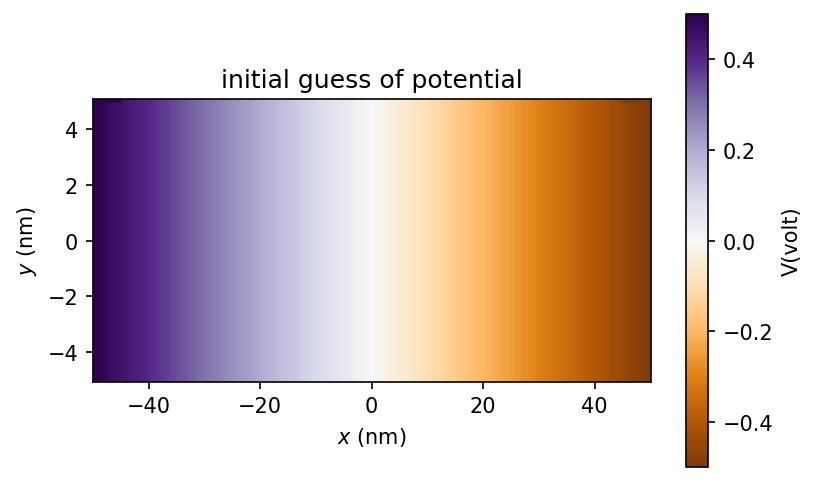

In [92]:
fig, ax = plt.subplots(dpi=150)
#plt.figure(dpi=150)
plt.pcolormesh(xv/1e-9,yv/1e-9,pot.transpose(),cmap="PuOr")
plt.colorbar(label=r'V(volt)')
plt.title(r"initial guess of potential")
plt.xlabel(r"$x$ (nm)")
plt.ylabel(r"$y$ (nm)")
ax.set_aspect(5)
plt.show()

In [100]:
Nt = 150000 # num of iteration 
t_start = time.time()
for it in range(Nt):
    pot = appl_BCs(pot)  
    pot_old = np.copy(pot) #https://numpy.org/doc/stable/reference/generated/numpy.copy.html
    pot[1:Nx-1,1:Ny-1] = 1/4 * (pot[0:Nx-2,1:Ny-1] + pot[2:Nx,1:Ny-1] + pot[1:Nx-1,0:Ny-2] + pot[1:Nx-1,2:Ny]) 
    err = LA.norm(pot-pot_old) # 
    rel_err = err/LA.norm(pot) 
          
t_end = time.time()
print(t_end - t_start)
print(err)
print(rel_err)

48.379717111587524
2.614927735989482e-07
3.677056079336261e-09


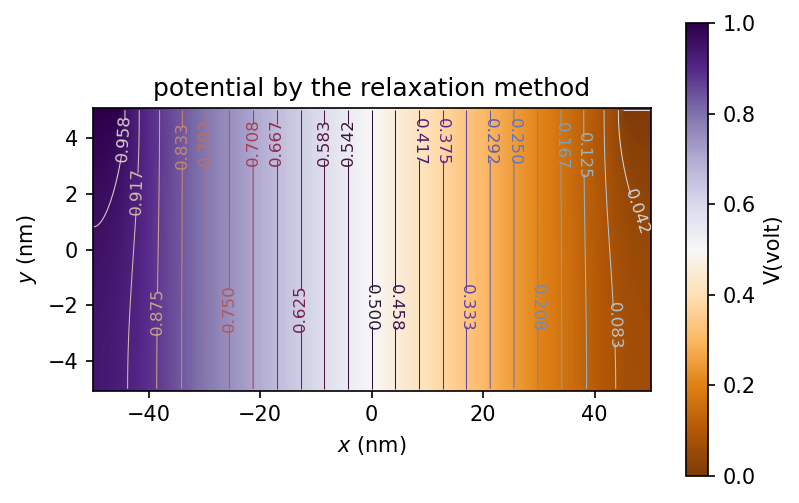

In [101]:
fig, ax = plt.subplots(dpi=150)
pot_plot = np.copy(pot + 0.5)
plt.pcolormesh(xv/1e-9,yv/1e-9,pot_plot.transpose()**1,cmap="PuOr")
plt.colorbar(label=r'V(volt)')
CS = ax.contour(xv/1e-9,yv/1e-9,pot_plot.transpose()**1,linewidths=0.5,cmap='twilight',levels=np.linspace(0,1,25))
ax.clabel(CS, inline=True, fontsize=8)
plt.title("potential by the relaxation method")
plt.xlabel(r"$x$ (nm)")
plt.ylabel(r"$y$ (nm)")
ax.set_aspect(5)
plt.show()

Compute the E field using
$$\mathbf{E} = -\nabla V.$$
In principle, you can write your own algorithm of gradient using the 
finite difference method. Here, we directly use the one from **numpy** package. You can refer to the [link](https://numpy.org/doc/stable/reference/generated/numpy.gradient.html) for more details.

In [102]:
# Use the gradient to get E field
# see https://numpy.org/doc/stable/reference/generated/numpy.gradient.html
E_field =  np.gradient(-pot,dx,dy)
# E_field[0] is Ex
# E_field[1] is Ey

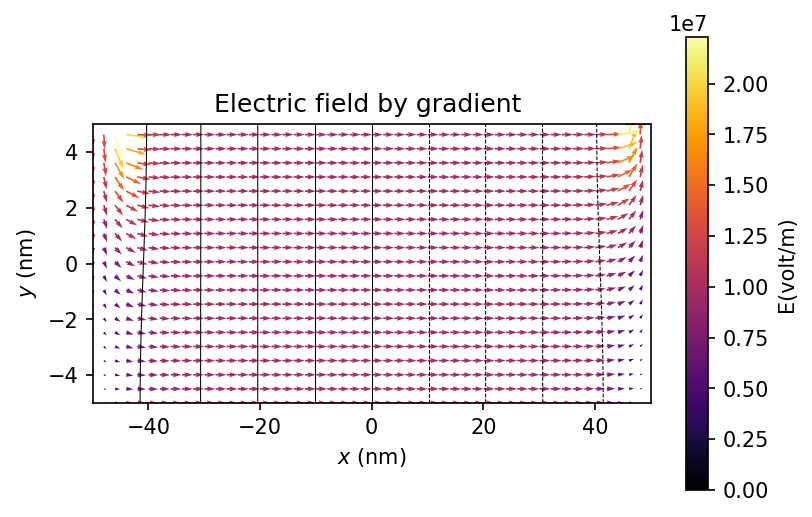

In [103]:
# Ref: https://pythonforundergradengineers.com/quiver-plot-with-matplotlib-and-jupyter-notebooks.html
fig, ax = plt.subplots(dpi=150)
#plt.subplot(2,1,1)
skip = (slice(None, None, 4), slice(None, None, 16)) ## make a sparse plot
Ex = E_field[0].transpose()**1
Ey = E_field[1].transpose()**1

color = np.sqrt((Ex[skip])**2 + (Ey[skip])**2)


plt.contour(xv/1e-9,yv/1e-9,pot.transpose()**1,linewidths=.5,colors='k',levels=np.linspace(-0.5,0.5,11))

plt.quiver(xm[skip]/1e-9,ym[skip]/1e-9,Ex[skip]/1e9,Ey[skip]/1e9,color,cmap=plt.cm.inferno,width= 0.003,scale=0.5)

plt.title("Electric field by gradient ")
plt.colorbar(label=r'E(volt/m)')
plt.xlabel(r"$x$ (nm)")
plt.ylabel(r"$y$ (nm)")
#plt.xlim([-lx/2,lx/2])
#plt.ylim([-ly/2,ly/2])
ax.set_aspect(5)
plt.show()


The current passing $x=0$ plane is 
$$ I = \int \mathbf{J}\cdot d\mathbf{a}$$
$$  =\Delta z \int J_x dy$$
$$  =\Delta z \sigma \int_{-5~\mathrm{nm}}^{5~\mathrm{nm}} E_x dy$$
$$R_{\mathbf{eff}}=\frac{V}{I}=\frac{\rho V}{\Delta z \int_{-5~\mathrm{nm}}^{5~\mathrm{nm}} E_x dy}$$

In [104]:
#
inte1 = np.sum(Ex[:,99]) * dy
rho = 1 # Ohm * cm
R_eff = 1 * 1/ inte1 # unit: 1 # Ohm * cm/(Delta z)  
print(R_eff)

10.205228002403777


$R_{\mathrm{eff}}$ = 10.24 $\frac{\Omega\mathrm{cm}}{z}$  

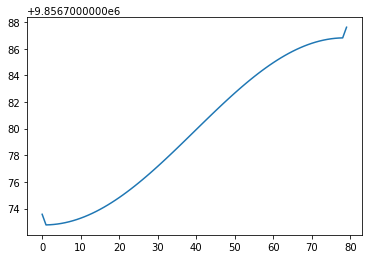

In [99]:

plt.plot(Ex[:,int(Nx/2)])
plt.show()
